In [3]:
#import basic libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
# import and configure matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [5]:

# import required model libraries
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.stattools as ts

In [6]:
# Where to save figures and model diagrams
# adapted code (Geron, 2019)
import os
IMAGES_PATH = os.path.join(".", "figures")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print('Saving figure: {}'.format(fig_id))
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, 
        dpi=resolution, bbox_inches = "tight")
    
MODEL_PATH = os.path.join(".", "models")
os.makedirs(MODEL_PATH, exist_ok=True)   

TABLE_PATH = os.path.join(".", "tables")
os.makedirs(TABLE_PATH, exist_ok=True) 

DATA_PATH = os.path.join(".", "data")
os.makedirs(DATA_PATH, exist_ok=True)

In [7]:
def read_time_series(file: str, index: str, start_date=None, freq='d') -> pd.DataFrame():
    """create dataframe of time series data
    Author: Mike Mattinson
    Date: June 22, 2022
    
    Parameters
    ----------
    file: str
       filename of time series data
    index: str
       column name of date index
    start_date: datetime
       (optional) if using specific start date
    freq: str
       (default) '24H' 24-hour increments
    
    Returns
    -------
    tsdf: pd.DataFrame()
       time series dataframe
    
    """
    
    # read and initialize index
    tsdf =  pd.read_csv(file)
    tsdf.set_index(index, inplace=True)
    
    # re-index on specific optional start_date
    index_label = 'Date'
    if(start_date is not None):
        tsdf[index_label] = (pd.date_range(
            start=start_date,
            periods=tsdf.shape[0],
            freq=freq))
        tsdf.set_index(index_label, inplace=True)
        tsdf['Year'] = tsdf.index.year
        tsdf['Month'] = tsdf.index.month
        #tsdf['Weekday Name'] = tsdf.index.weekday_name
                    
    # print out summary
    print(tsdf.info())
    print(tsdf.shape)
    print(tsdf.sample(5, random_state=0))
    
    return tsdf # time series dataframe

In [8]:
# read time series data from CSV file
from datetime import datetime
df =  read_time_series(
    file='E:/HDD Documents/HDD Documents/School/WGU/churn/teleco_time_series.csv', 
    index='Day', freq='d', 
    start_date=datetime(2020,1,1)
)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2020-01-01 to 2021-12-30
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  730 non-null    float64
 1   Year     730 non-null    int64  
 2   Month    730 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 22.8 KB
None
(730, 3)
              Revenue  Year  Month
Date                              
2020-07-15   5.328601  2020      7
2020-07-06   5.816199  2020      7
2020-01-15   1.085547  2020      1
2020-02-01   2.442888  2020      2
2021-01-25  11.234359  2021      1


In [9]:
# show sample from dataframe
df.iloc[::100, :]

,Revenue,Year,Month
Date,,,
2020-01-01,0.000000,2020,1
2020-04-10,6.487956,2020,4
2020-07-19,6.419180,2020,7
2020-10-27,10.785571,2020,10
2021-02-04,12.281446,2021,2
2021-05-15,12.980905,2021,5
2021-08-23,14.651651,2021,8
2021-12-01,15.269829,2021,12


In [10]:
# drop zero values
df= df[df['Revenue'] != 0]

In [11]:
# descripe numerical data
df.describe()

,Revenue,Year,Month
count,729.000000,729.000000,729.000000
mean,9.849038,2020.499314,6.519890
std,3.825359,0.500343,3.444609
min,0.000793,2020.000000,1.000000
25%,6.916245,2020.000000,4.000000
50%,10.804153,2020.000000,7.000000
75%,12.568041,2021.000000,10.000000
max,18.154769,2021.000000,12.000000


In [12]:
#find rolling mean of previous n periods
n_days = 30
df['rolling_mean'] = df['Revenue'].rolling(n_days).mean()
df['rolling_std'] = df['Revenue'].rolling(n_days).std()

In [13]:
#check missing data
df.isnull().any()

Revenue         False
Year            False
Month           False
rolling_mean     True
rolling_std      True
dtype: bool

In [14]:
# export cleaned data to file
df.to_csv('tables\cleaned.csv', index=True, header=True)
print(df.info())
print(df.shape)
print(df.iloc[::100, :])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 2020-01-02 to 2021-12-30
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Revenue       729 non-null    float64
 1   Year          729 non-null    int64  
 2   Month         729 non-null    int64  
 3   rolling_mean  700 non-null    float64
 4   rolling_std   700 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 34.2 KB
None
(729, 5)
              Revenue  Year  Month  rolling_mean  rolling_std
Date                                                         
2020-01-02   0.000793  2020      1           NaN          NaN
2020-04-11   6.055527  2020      4      6.782663     0.687540
2020-07-20   6.770456  2020      7      5.870610     0.420109
2020-10-28   9.760365  2020     10     10.492095     0.703232
2021-02-05  12.052705  2021      2     11.369189     0.754945
2021-05-16  12.909134  2021      5     13.000165     0.689036
2021-08-24  14.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 729 entries, 2020-01-02 to 2021-12-30
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Revenue       729 non-null    float64
 1   Year          729 non-null    int64  
 2   Month         729 non-null    int64  
 3   rolling_mean  700 non-null    float64
 4   rolling_std   700 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 34.2 KB


In [17]:
# equation of poly fit 
from sympy import S, symbols, printing
x = pd.Series(range(df.shape[0]))
y = df['Revenue'].values
n_deg = 3
p = np.polyfit(x, y, deg=n_deg)
f = np.poly1d(p)
e = symbols("x")
poly = sum(S("{:6.7f}".format(v))*e**i for i, v in enumerate(p[::-1]))
eq_latex = printing.latex(poly)
print(p)
print(poly) # won't include zero terms

[ 4.51657462e-08 -6.81697467e-05  4.45492435e-02  1.32180215e+00]
-6.82e-5*x**2 + 0.0445492*x + 1.3218021


Saving figure: Revenue ($M)


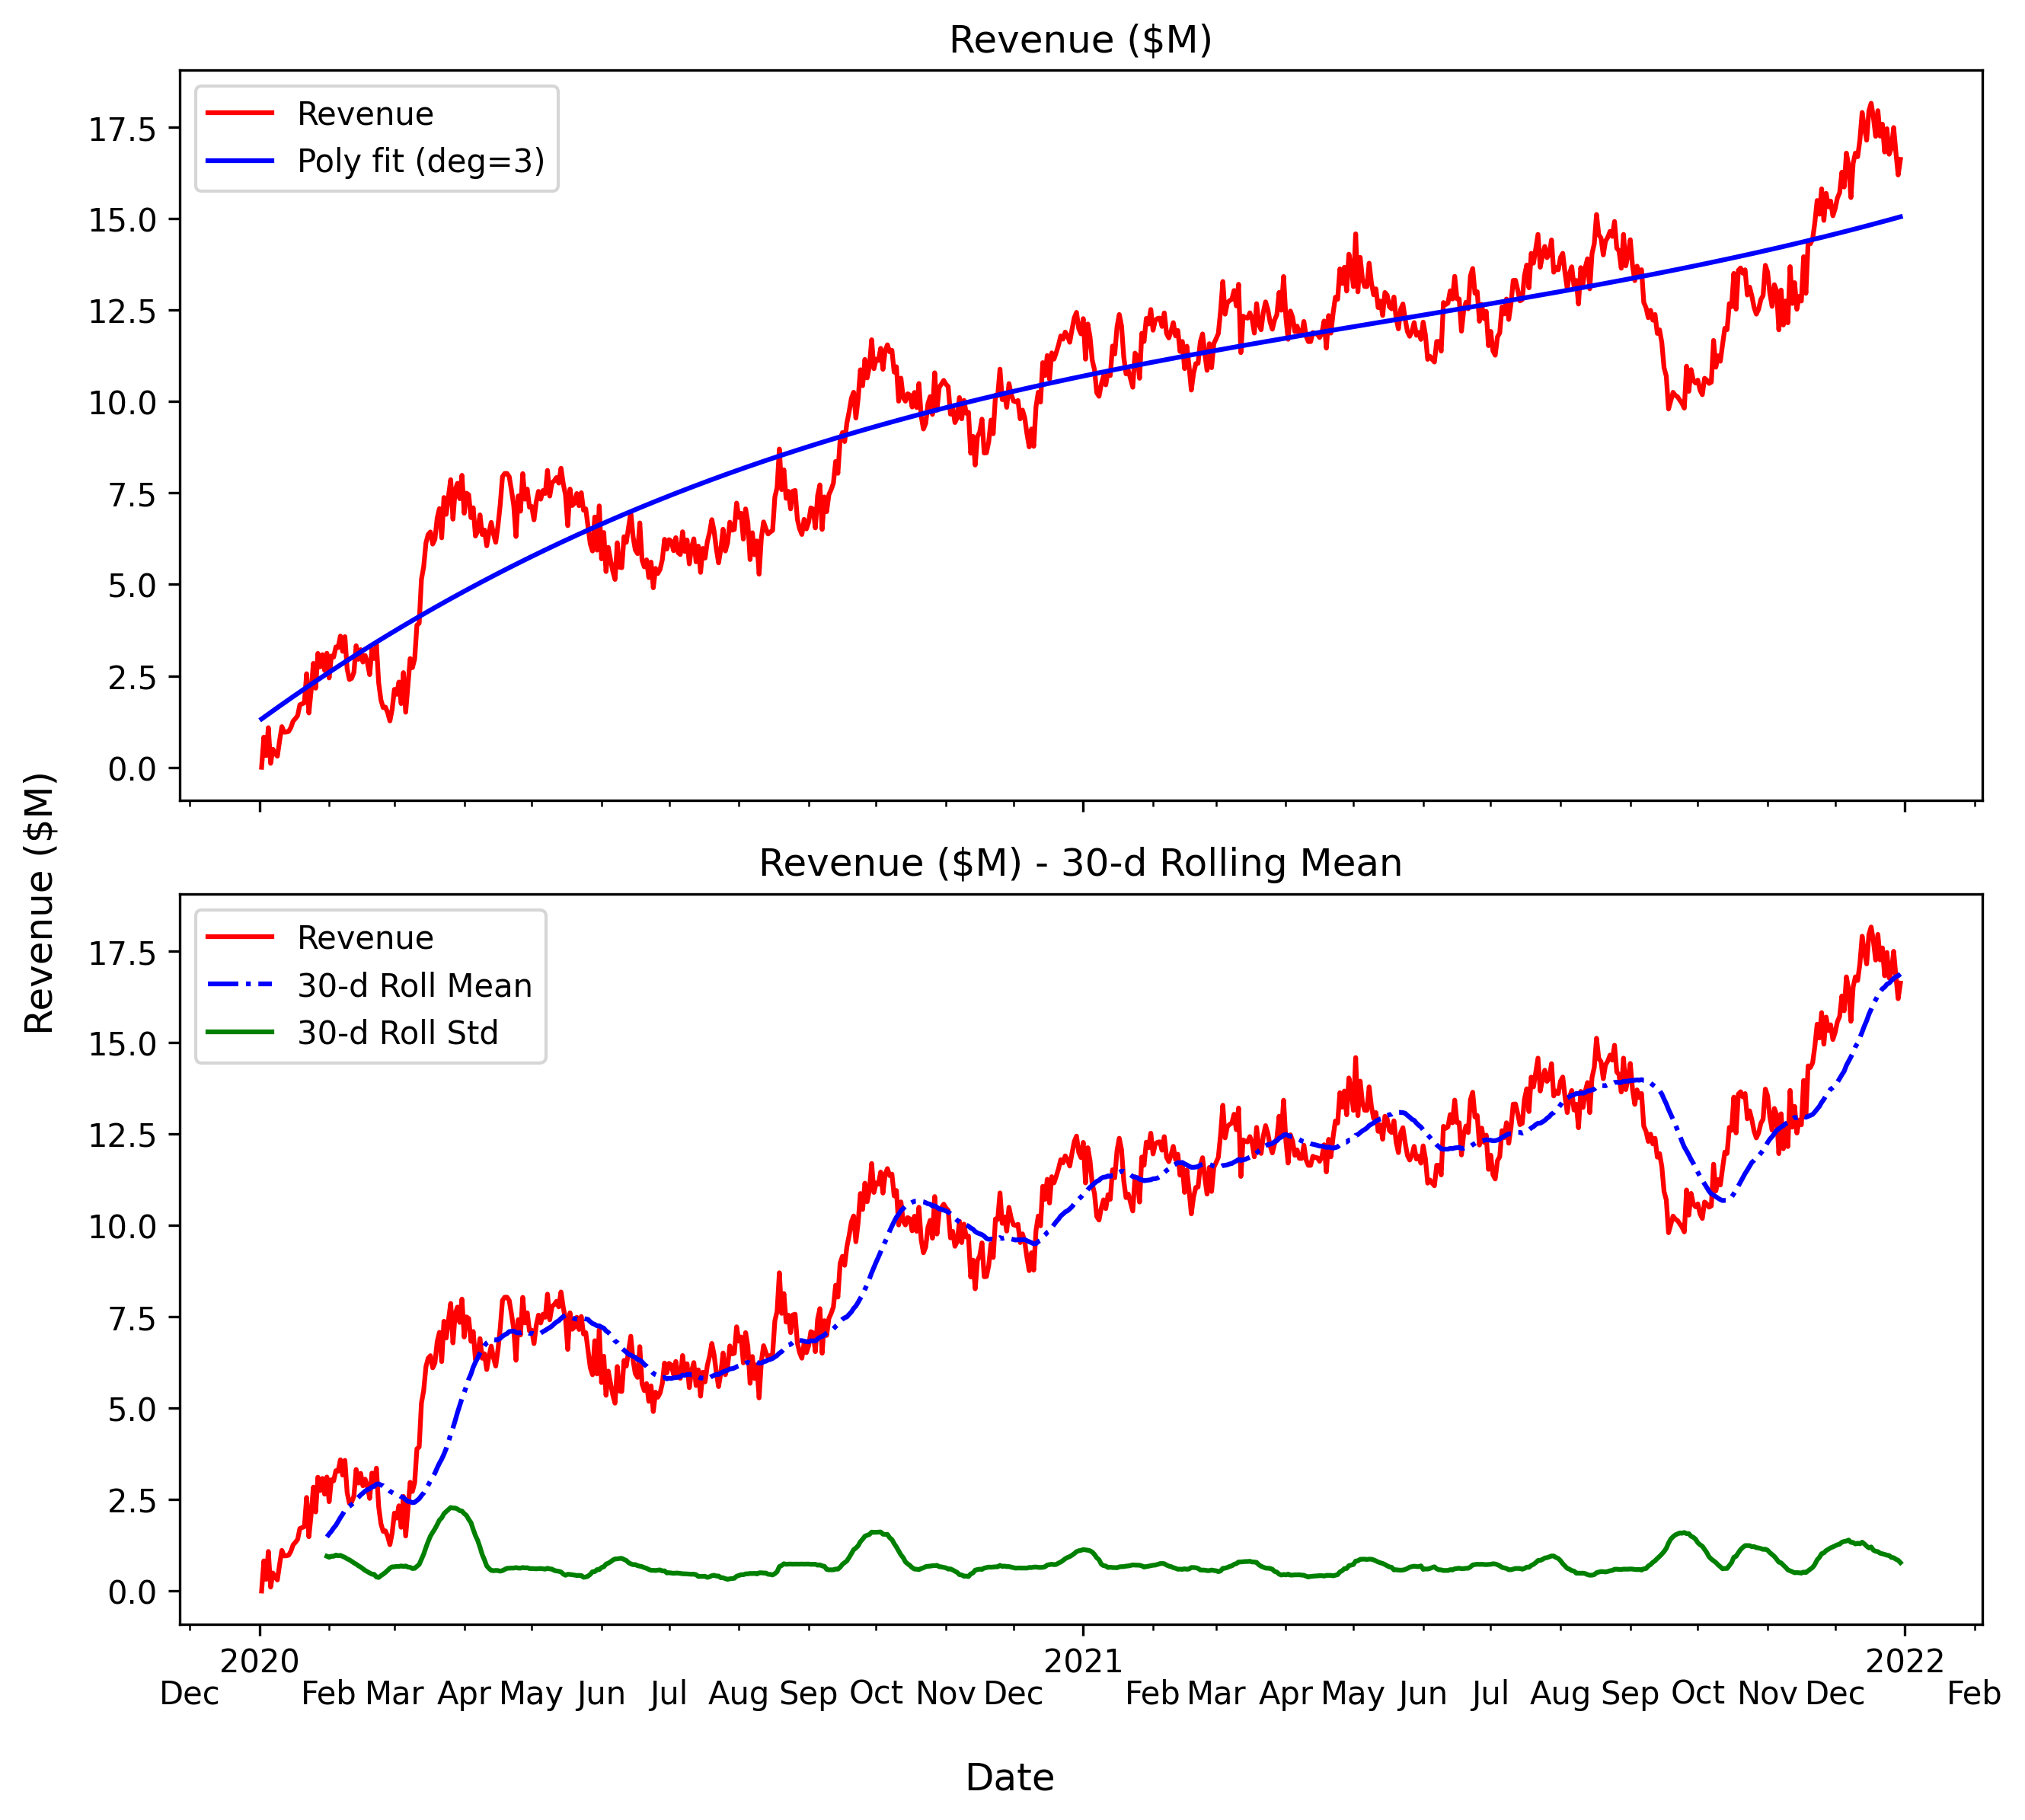

In [18]:
# visualize raw revenue data
x = pd.Series(df.index.values) # if using date
x2 = pd.Series(range(df.shape[0])) # if using date index
fig, ax = plt.subplots(2,1, figsize = (9, 8), sharex=True, sharey=True)
ax[0].plot(x, df.Revenue, 'r-', label='Revenue')
ax[1].plot(x, df.Revenue, 'r-', label='Revenue')
ax[0].plot(x,f(x2),"b", label='Poly fit (deg=' + str(n_deg) + ')')
ax[0].legend()
ax[0].set_title('Revenue ($M)')
ax[1].plot(x,df['rolling_mean'], "b-.",
         label=str(n_days) + '-d Roll Mean')
ax[1].plot(x,df['rolling_std'], "g", 
         label=str(n_days) + '-d Roll Std')
ax[1].set_title('Revenue ($M) - 30-d Rolling Mean')
ax[1].legend()
import matplotlib.dates as mdates
ax[1].xaxis.set_major_locator(mdates.YearLocator())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax[1].xaxis.set_minor_locator(mdates.MonthLocator())
ax[1].xaxis.set_minor_formatter(mdates.DateFormatter('\n%b'))
fig.supxlabel('Date') # common x label
fig.supylabel('Revenue ($M)') # common y label
#plt.gcf().text(0, -.1, "${}$".format(eq_latex), fontsize=14)
title = 'Revenue ($M)'
save_fig(title) 

In [19]:
import statsmodels.tsa.stattools as ts
def dickey_fuller(
    array: np.array, 
    critical=0.05,
    stats=False) -> float:
    """return p-value of augmented dickey-fullter test
    Author: Mike Mattinson
    Date: June 29, 2022
    
    Parameters
    ----------
    array: np.array # array-like
       array of values to be evaluated
    critical: float (default=0.05)
       critical value
    stats: bool (default=False)
        include stats is output or not
    
    Returns
    -------
    pvalue: float
        p-value

    """
    result = ts.adfuller(array, autolag='AIC')
    pvalue = result[1]
    
    if(stats):
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % pvalue)
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
    
    if pvalue <= critical:
        print('Reject H0, data is stationary.')
    else:
        print('Accept H0, data is non-stationary.')
    
    return pvalue

In [20]:
# augmented dickey-fuller
dickey_fuller(df['Revenue'].values, stats=True)

ADF Statistic: -1.787175
p-value: 0.386847
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
Accept H0, data is non-stationary.


0.3868472463695337

In [21]:
"""Calculates difference of Dataframe element compared with another 
element in the Dataframe (default is element in previous row)."""
df_stationary = df.diff(periods=1,axis=0).dropna()
print(df_stationary.info())
print(df_stationary.shape)
#print(df_stationary.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 699 entries, 2020-02-01 to 2021-12-30
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Revenue       699 non-null    float64
 1   Year          699 non-null    float64
 2   Month         699 non-null    float64
 3   rolling_mean  699 non-null    float64
 4   rolling_std   699 non-null    float64
dtypes: float64(5)
memory usage: 32.8 KB
None
(699, 5)


In [22]:
# augmented dickey-fuller
dickey_fuller(df_stationary['Revenue'].values, stats=True)

ADF Statistic: -43.503317
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Reject H0, data is stationary.


0.0

In [23]:
# export stationary data to file
df_stationary.to_csv('tables\stationary.csv', index=True, header=True)
print(df_stationary.info())
print(df_stationary.shape)
print(df_stationary.iloc[::100, :])

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 699 entries, 2020-02-01 to 2021-12-30
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Revenue       699 non-null    float64
 1   Year          699 non-null    float64
 2   Month         699 non-null    float64
 3   rolling_mean  699 non-null    float64
 4   rolling_std   699 non-null    float64
dtypes: float64(5)
memory usage: 32.8 KB
None
(699, 5)
             Revenue  Year  Month  rolling_mean  rolling_std
Date                                                        
2020-02-01 -0.675342   0.0    1.0      0.081403    -0.026838
2020-05-11  0.050562   0.0    0.0      0.059181    -0.035008
2020-08-19  1.049345   0.0    0.0      0.064358     0.140500
2020-11-27  0.177593   0.0    0.0      0.015650     0.008290
2021-03-07  0.062254   0.0    0.0      0.023540     0.027416
2021-06-15  0.620871   0.0    0.0      0.017117     0.031645
2021-09-23 -0.091047   0.0    0.0

In [24]:
#setup training and test data 80/20
test_size = int(.20 * df_stationary.shape[0])  # last 20%
train, test = train_test_split(df, test_size=test_size, shuffle=False)
print('training: {}'.format(train.shape))
print('testing: {}'.format(test.shape))

training: (590, 5)
testing: (139, 5)


Saving figure: ACF-PACF on training data


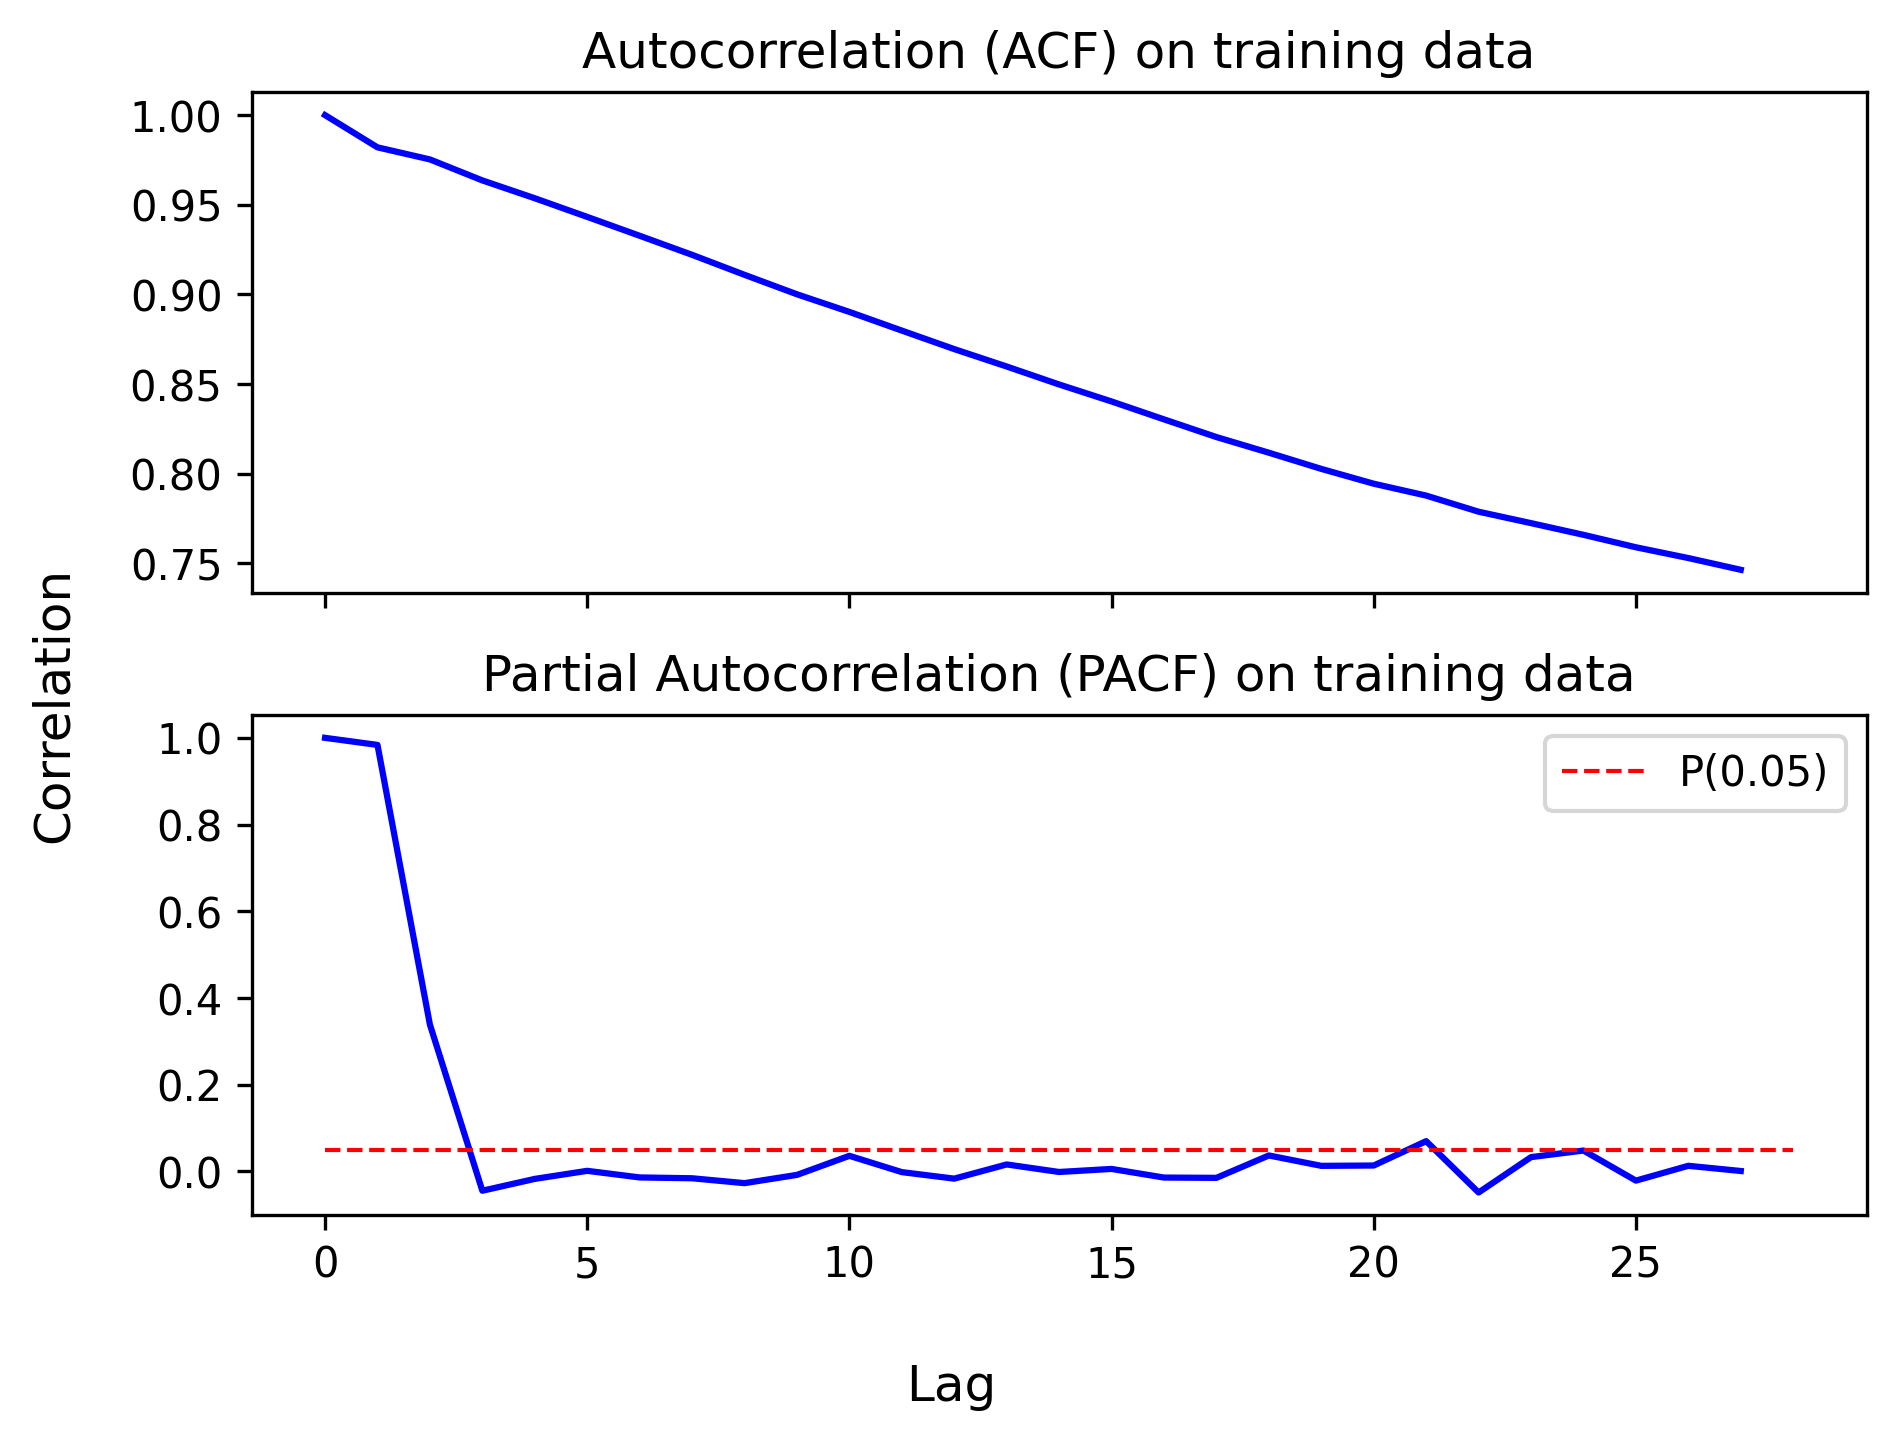

In [25]:
# autocorrelation/partial autocorrleation
acf_series = acf((train['Revenue'].values))
acf_df = pd.DataFrame([acf_series]).T
acf_df.columns = ['ACF']
pacf_series = pacf((train['Revenue'].values))
pacf_df = pd.DataFrame([pacf_series]).T
pacf_df.columns = ['PACF']
fig, ax = plt.subplots(2,1, sharex=True, sharey=False)
ax[0].plot(acf_df.ACF, 'b-')
ax[1].plot(pacf_df.PACF, 'b-')
fig.supxlabel('Lag') # common x label
fig.supylabel('Correlation') # common y label
ax[1].hlines(y=0.05, xmin=0, xmax=len(pacf_series), lw=1, 
             linestyles='--', color='r', label='P(0.05)')
ax[1].legend()
title = 'ACF-PACF on training data'
ax[0].set_title('Autocorrelation (ACF) on training data')
ax[1].set_title('Partial Autocorrelation (PACF) on training data')
save_fig(title)

Saving figure: Decomposition on cleaned data


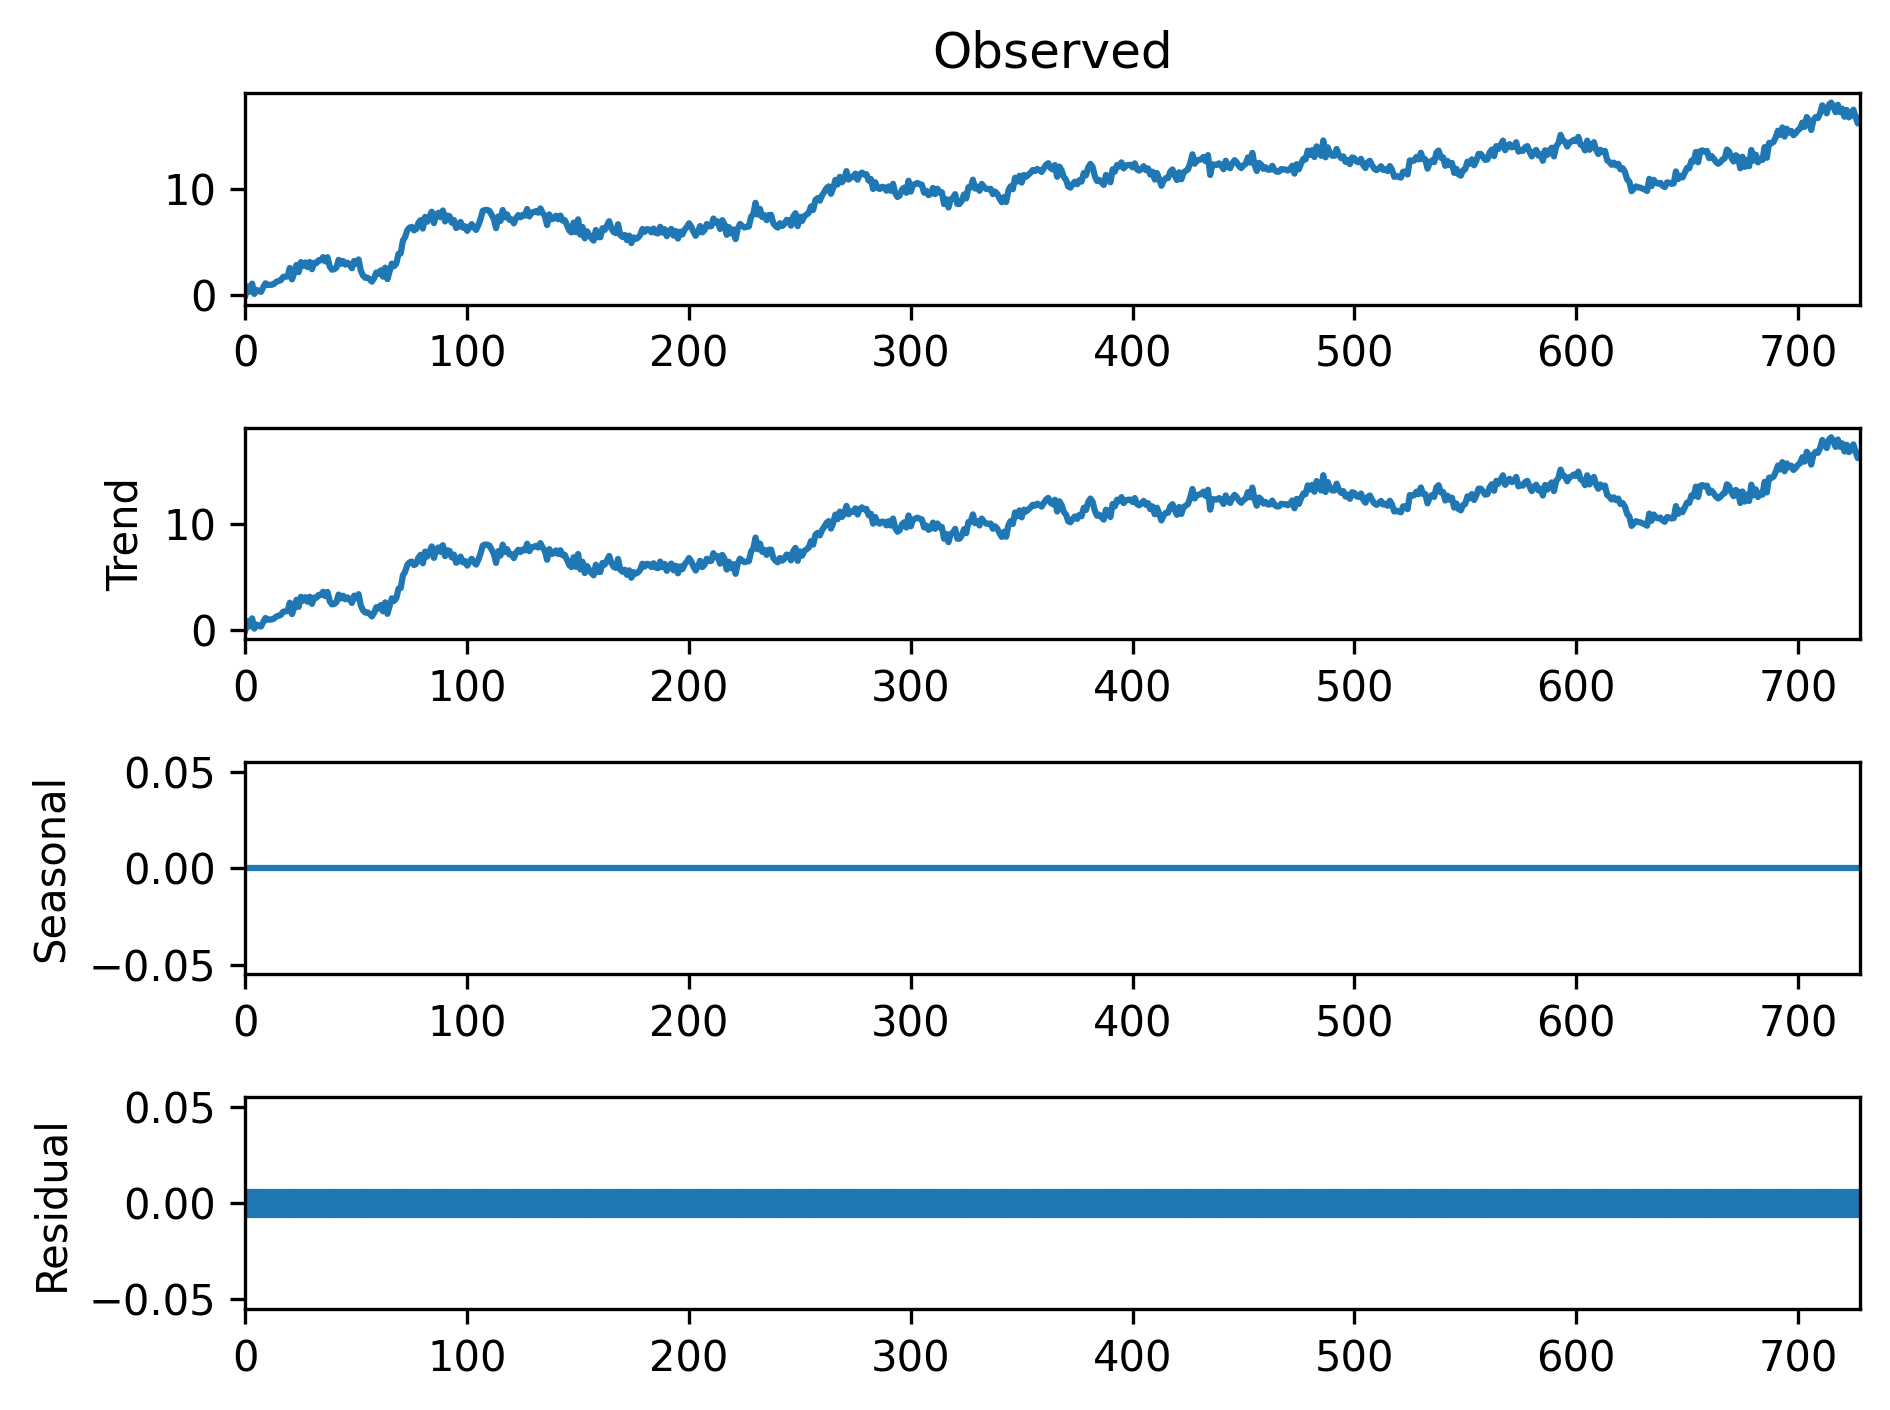

In [26]:
# decompose cleaned data - additive
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Revenue'].values, 
            model='additive', period=1)
result.plot()
title = 'Decomposition on cleaned data'
save_fig(title)

In [27]:
# run model and predict
X_train = np.array(train['Revenue'])
model = ARIMA(X_train, order=(0,1,0))
arima_v1 = model.fit()
print(arima_v1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  590
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -459.398
Date:                Thu, 15 Dec 2022   AIC                            920.795
Time:                        19:38:03   BIC                            925.174
Sample:                             0   HQIC                           922.501
                                - 590                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2786      0.017     16.095      0.000       0.245       0.313
Ljung-Box (L1) (Q):                 126.65   Jarque-Bera (JB):                 2.41
Prob(Q):                              0.00   Pr

In [28]:
# predict next 9 time step values
n_predictions = 9; last_time = 730
predictions = arima_v1.predict(700,710, type='levels')
predictions

array([13.90272062, 13.90272062, 13.90272062, 13.90272062, 13.90272062,
       13.90272062, 13.90272062, 13.90272062, 13.90272062, 13.90272062,
       13.90272062])

Saving figure: Predictions


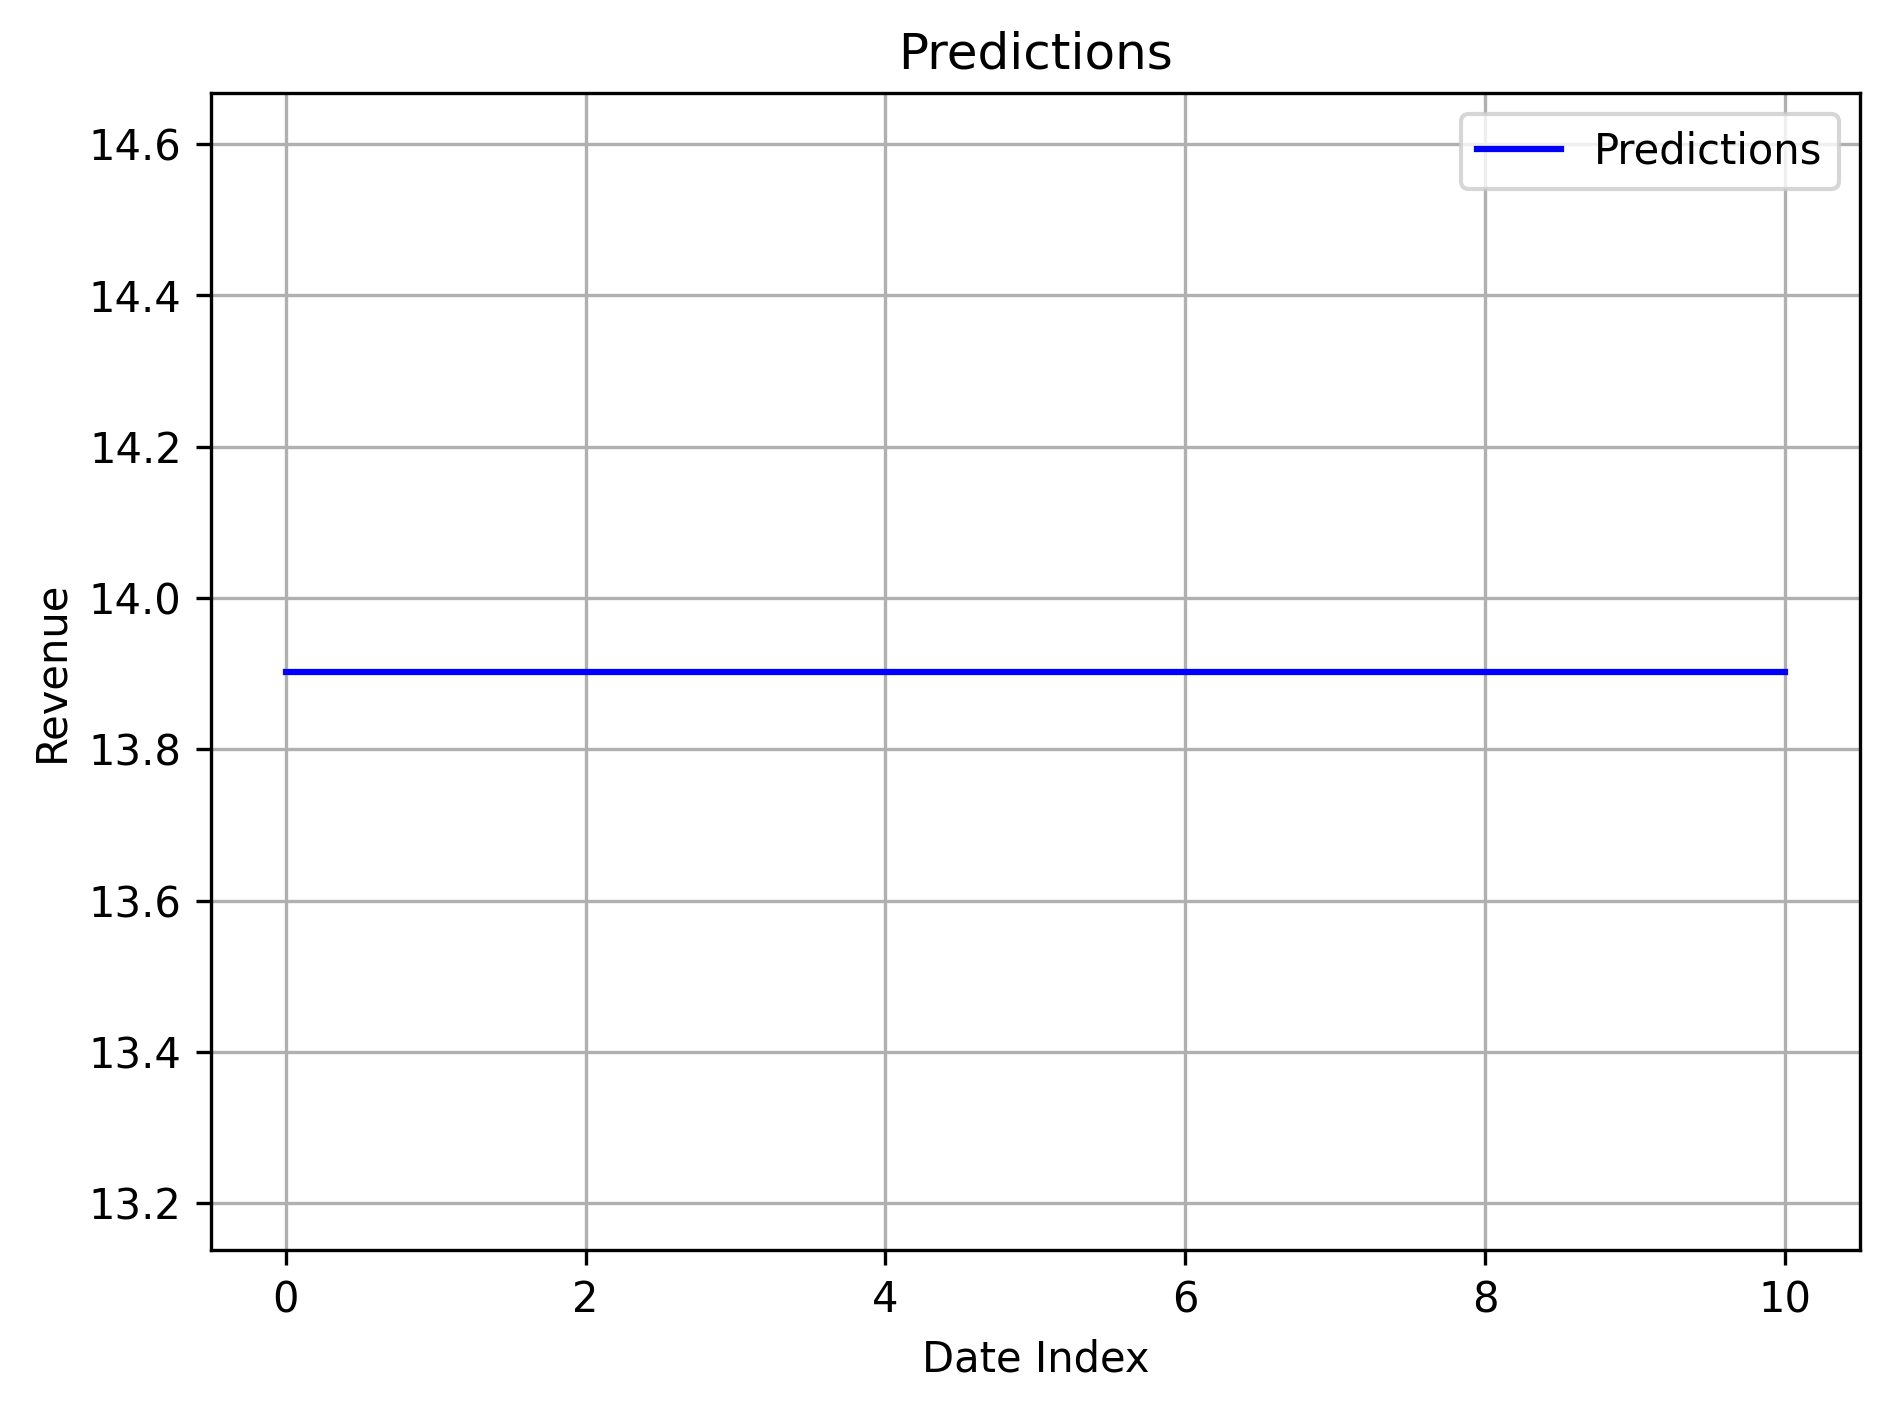

In [29]:
x = range(len(predictions))
fig, ax = plt.subplots()
ax.plot(x, predictions, "b", label='Predictions')
plt.xlabel("Date Index")
plt.ylabel("Revenue")
title = 'Predictions'
plt.locator_params(axis="both", 
      integer=True, tight=False)
plt.legend()
plt.grid()
plt.title(title)
save_fig(title) 

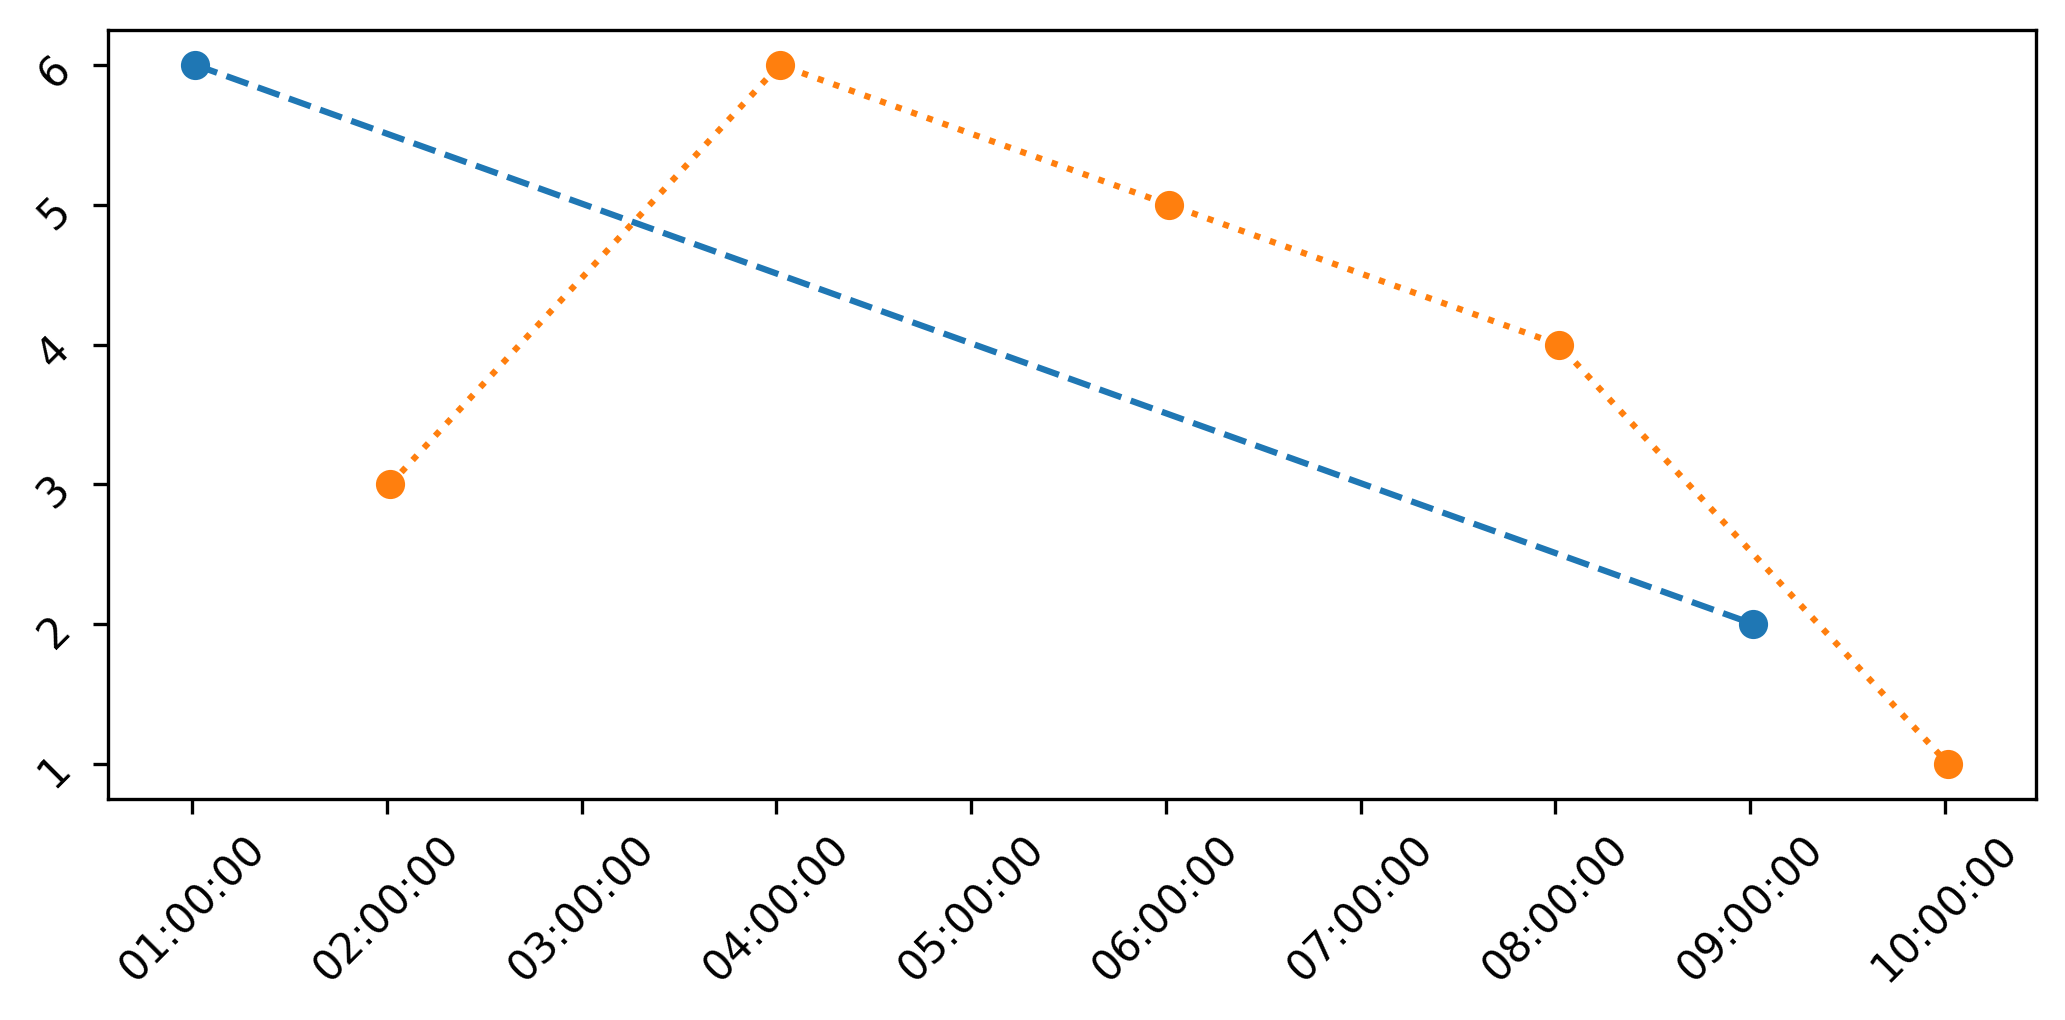

In [30]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter
import datetime as dt

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

x1 = [date2num(dt.datetime(2021, 1, 15, 1, 1, 1)), date2num(dt.datetime(2021, 1, 15, 9, 1, 1))]

y1 = [6, 2]

x2 = [ date2num(dt.datetime(2021, 1, 15, 2, 1, 1)),
    date2num(dt.datetime(2021, 1, 15, 4, 1, 1)),
    date2num(dt.datetime(2021, 1, 15, 6, 1, 1)),
    date2num(dt.datetime(2021, 1, 15, 8, 1, 1)),
    date2num(dt.datetime(2021, 1, 15, 10, 1, 1))
]

y2 = [3, 6, 5, 4, 1]

fig, ax = plt.subplots()

ax.plot_date(x1, y1, 'o--')
ax.plot_date(x2, y2, 'o:')

ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
ax.tick_params(rotation=45)

plt.show()

[Text(0, 0.5, 'y axis label'),
 Text(0, 0.5, 'y axis label'),
 Text(0, 0.5, 'y axis label')]

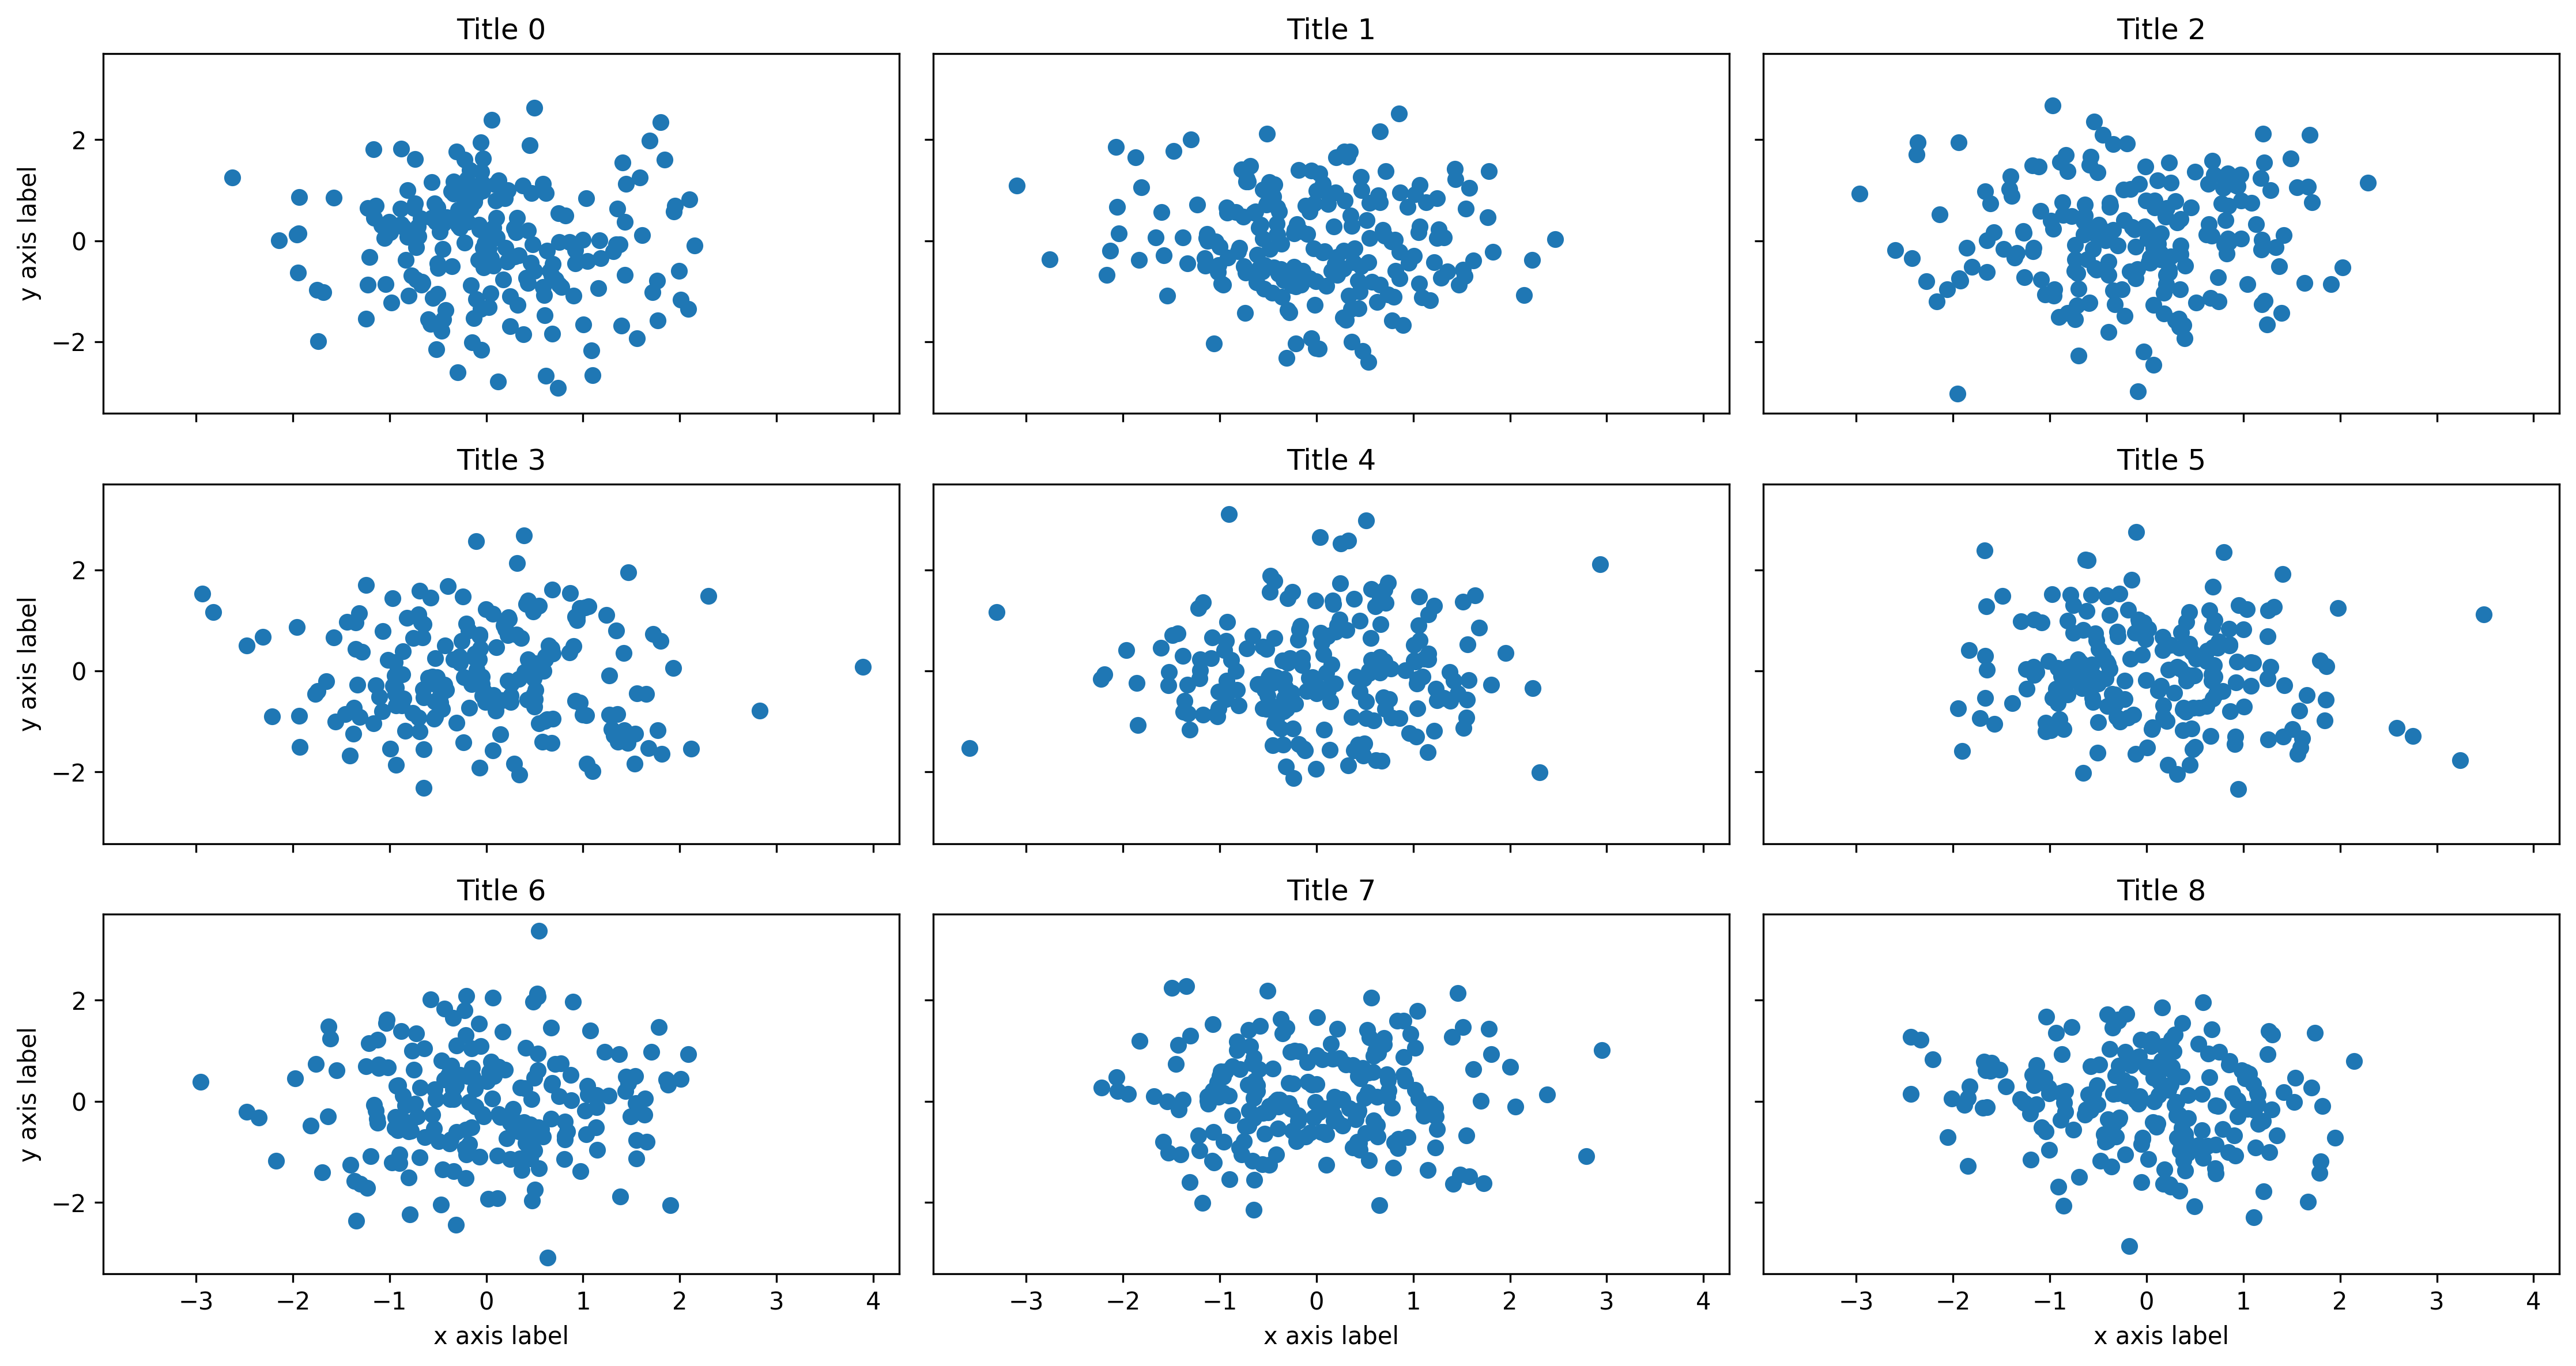

In [31]:

# plot something
fig, axs = plt.subplots(3,3, figsize=(15, 8), sharex=True, sharey=True)
for i, ax in enumerate(axs.flat):
    ax.scatter(*np.random.normal(size=(2,200)))
    ax.set_title(f'Title {i}')

# set labels
plt.setp(axs[-1, :], xlabel='x axis label')
plt.setp(axs[:, 0], ylabel='y axis label')